### Test of data instantiation

In [1]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader 
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import os
from torchmetrics import FBetaScore, Accuracy
from torchvision.utils import draw_bounding_boxes

import torchvision.transforms as T
from torchvision.transforms import functional as F

import pandas as pd
import src.dfmaker as dfmaker
import src.BWDatasets as BWDatasets

from paddleocr import PaddleOCR
import paddle


c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


### Ensure Reproducibility

In [2]:
seed = 115
generator = torch.Generator()
generator.manual_seed(seed)
np_generator = np.random.default_rng(seed=seed)

### Activate CUDA

In [3]:
device = torch.device('cpu')

# Make sure the notebook is deterministic if training on gpu
if torch.cuda.is_available():
    device = torch.device('cuda')
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False

print(f'Cuda availability is: {torch.cuda.is_available()}')  # Returns True if a GPU is available
print(f"Training on device {device}.")

Cuda availability is: True
Training on device cuda.


In [4]:
# Lyngøy
label_path_lyng = "dataset/datasets/lyngoy/ringcodes.csv"
image_path_lyng = "dataset/datasets/lyngoy/images"
bb_path_lyng = "dataset/datasets/lyngoy/labels"

# RF
label_path_rf = "dataset/datasets/rf/ringcodes.csv"
image_path_rf = "dataset/datasets/rf/images"
bb_path_rf = "dataset/datasets/rf/labels"

# Ringmerkingno
label_path_rno = "dataset/datasets/ringmerkingno/ringcodes.csv"
image_path_rno = "dataset/datasets/ringmerkingno/images"
bb_path_rno = "dataset/datasets/ringmerkingno/labels"

max_n_single = 400
max_n_all = None
transform = T.Compose([
    # T.Resize((64,32)),
    T.Resize((224,112)),
    T.Lambda(lambda x: F.rotate(x, 270, expand=True))
])

df_lyng = dfmaker.make_dataframe(labels_path=label_path_lyng, img_path=image_path_lyng, bb_path=bb_path_lyng, max_n=max_n_single)
df_rf = dfmaker.make_dataframe(labels_path=label_path_rf, img_path=image_path_rf, bb_path=bb_path_rf, max_n=max_n_single)
df_rno = dfmaker.make_dataframe(labels_path=label_path_rno, img_path=image_path_rno, bb_path=bb_path_rno, max_n=max_n_single)
complete_df = dfmaker.combine_dfs([df_lyng, df_rf, df_rno])

exp_dataset = BWDatasets.TrainDataSet(df=complete_df, transform=transform, max_n=max_n_all)


In [5]:
def draw_image(img):
    img_uint8 = BWDatasets.tensor_to_numpy(img)
    plt.figure(figsize=(12,12))
    plt.imshow(img_uint8)
    plt.axis("off")
    plt.show()

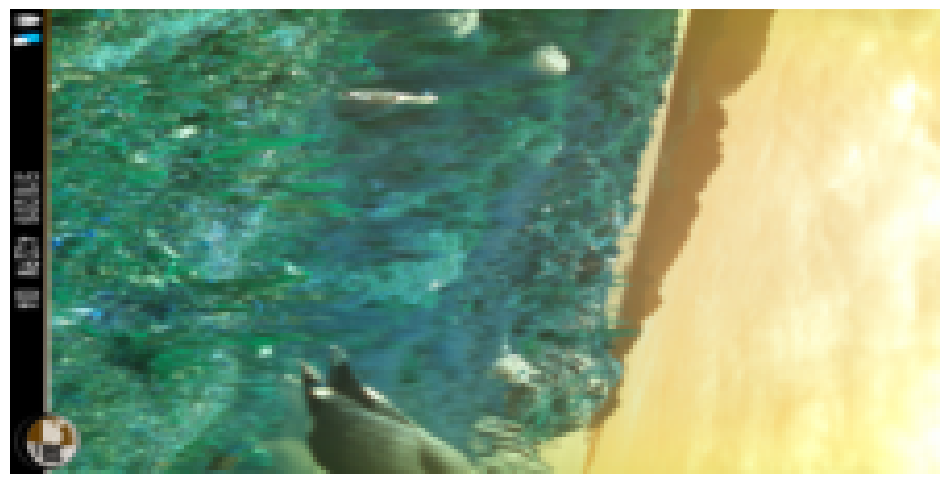

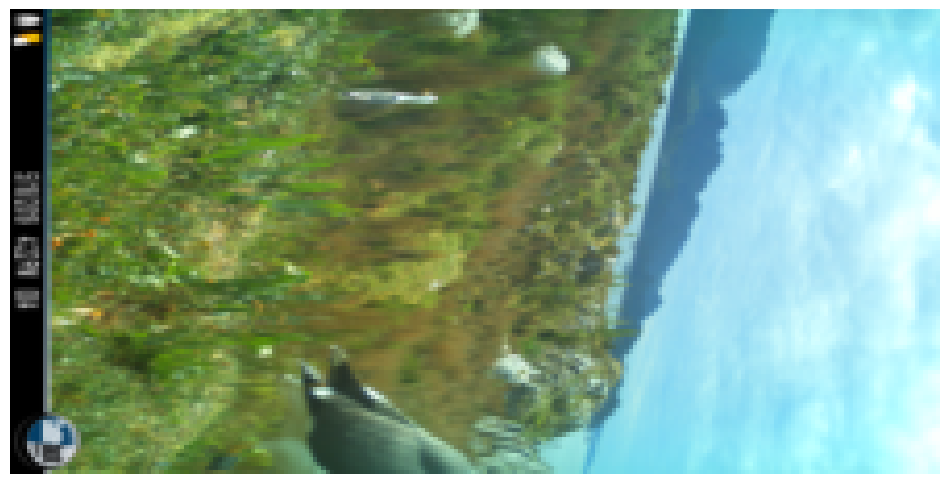

None


In [6]:
data = exp_dataset[1]

draw_image(data["ocr_image"])
draw_image(data["image"])

print(data['bb'])

In [7]:
#stop



In [8]:
paddle.device.set_device("gpu:0")
ocr = PaddleOCR(lang="en", 
        #    text_detection_model_dir="src/models/paddleOCR/det", 
        #    text_recognition_model_dir="src/models/paddleOCR/rec", 
        #    textline_orientation_model_dir="src/models/paddleOCR/cls", 
           use_doc_orientation_classify=True, 
           use_doc_unwarping=True, 
           use_textline_orientation=True, device='gpu')


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 5719.51it/s]
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 3242.18it/s]
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 5770.65it/s]
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [

In [9]:

exp_loader = DataLoader(dataset=exp_dataset, batch_size=64, shuffle=False, generator=generator)


In [10]:
def prediction(dataloader):
    preds = []
    targets = []
    count = 0
    for data in dataloader:
        count +=1
        print(f'Batch {count} of {len(dataloader)}')
        images = BWDatasets.tensor_to_numpy(data["ocr_image"])
        labels = data["label"][0]
        for i, image in enumerate(images):
            
            result = ocr.predict(image)

            pred = result[0]["rec_texts"]

            if not pred:
                pred = ['Not Found']

            preds.append(pred[0])

            label = labels[i]
            
            targets.append(label)

            # print("-------------------")
            # print(f'Prediction: {pred}')
            # print(f'Actual: {label}')

            # plt.figure(figsize=(4,2))
            # plt.imshow(image, cmap="gray")
            # plt.axis("off")
            # plt.show()
    return preds, targets


In [11]:
def evaluate_model(preds, labels):
    print(f'preds: {preds}')
    print(f'labels: {labels}')
    
    # Boolean mask for the predictions and the labels
    # Prediction = 1 if it is correct, 0 otherwise
    # Labels are always = to 1
    bin_preds = [int(pred == label) for pred, label in zip(preds, labels)]
    bin_labels = [1]*len(labels)

    preds_tensor, labels_tensor = torch.tensor(bin_preds), torch.tensor(bin_labels)
    fbeta = FBetaScore(task='binary', beta=0.5)
    acc = Accuracy(task='binary')

    print(f'Model F1 Score: {fbeta(preds_tensor, labels_tensor)}')
    print(f'Model Accuracy: {acc(preds_tensor, labels_tensor)}')
    # print(f'preds: {preds_tensor}')
    # print(f'labesl: {labels_tensor}')

In [12]:
preds, labels = prediction(exp_loader)


KeyboardInterrupt: 

In [ ]:
evaluate_model(preds=preds, labels=labels)


preds: ['Not Found', 'Not Found', 'Not Found', '3300', 'ZB', 'Not Found', 'HL', 'Not Found', '2A00', 'Not Found', 'eonel', 'Not Found', 'Not Found', '22', 'Not Found', 'J6KV', 'JC78T', 'Not Found', 'Not Found', 'CN', 'Not Found', 'Not Found', 'JJ94C', 'Not Found', 'Not Found', 'Not Found', '5ED', '566', 'Not Found', 'Not Found', 'Not Found', 'AEZZE', 'J2XK', 'Not Found', 'Not Found', 'Not Found', '1S115', 'Not Found', 'Not Found', '670', 'JL084', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', '760', 'Not Found', '27761', 'Not Found', 'Not Found', 'dxgr', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'ASZL', 'Not Found', 'Not Found', 'Not Found', 'JYOG', 'Not Found', 'JUN', 'Not Found', 'Not Found', 'AZ0', 'J8RE', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', '2V04', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'J8RE', 'Not Found', 'Not Found', 'A808C', 'Not Found', 'Not Found', 'Not Fo